In [ ]:
# Cargar los datos y obtener el modelo
from common import *
#del perform_sensitivity_analysis ### AUX TEMP: ELIMINO EL IMPORT DE ESTA FN XQ ESTOY PROBANDO
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 12800
* Total benefit=12800
Production of A: 0
Production of B: 80.0
Production of C: 320.0


In [ ]:
#***Added by JL - 2024 Mar 03th - Checking sensitivity analysis *****')

# Initialize lists to store the results
# rhs_values = []
# dual_values = []

#real_rhs_value = 0

m = 0.01


In [ ]:
# # Report values for the chart

# def report(x_list, y_list, rhs_value, constraint_nameY):
#     x_list.append(rhs_value)
#     y_list.append(constraint_nameY.dual_value) #Diferencia con grafico Costo Op dem min B vs disp
    


In [ ]:
#### PROBANDOOOOOOOOOOOO
constraint_nameX = 'Disp_Equipo2'  # The name of the constraint X to analyze
constraint_nameY = mdl.get_constraint_by_name(constraint_nameX)

# # Perform sensitivity analysis of the RHS
# ### Aux: VM, Funcional, costo op
# # Constraint es el nombre de la restricción cuyos lower y upper bounds queremos obtener,
# def perform_sensitivity_analysis(mdl, constraint):
#     lp = LinearRelaxer.make_relaxed_model(mdl)
#     lp.solve()
#     cpx = lp.get_engine().get_cplex()

#     rhs=cpx.solution.sensitivity.rhs()
#     names = cpx.linear_constraints.get_names()
#     print("[DEBUG] NOMBRES DE LAS RESTRICCIONES:\n", names)
#     idx=names.index(constraint)
#     print(f"Lower y upper para restr: {constraint}: {rhs[idx]}")
    
#     return rhs[idx]

In [ ]:
# def iterate_left(c, lower):
#     x_list = []
#     y_list = []
#     rhs = lower - m
#     while True:
#         print("[debug] Viendo para rhs:", rhs)
#         if rhs < 0:
#             break ## Stop if the rhs is lower than 0                
    
#         solution = solve(c, rhs, mdl, products, produccion_vars)
#         if solution is None:
#             break  # Stop if the model is infeasible
#         else:
#             #report(rhs, constraint_nameY.dual_value) #Diferencia con grafico funcional vs disp
#             #report(c_sens.rhs.constant, constraint_nameY.dual_value) ### Aux, veamos si así queda 126 y no 125.99
#             print("[debug al append] rhs:", rhs)
#             print("[debug al append] c_sens.rhs.constant:", c.rhs.constant)
#             report(x_list, y_list, rhs + m, constraint_nameY.dual_value)
            
#         # Perform sensitivity analysis to get the new lower bound
#         new_sensitivity = perform_sensitivity_analysis(mdl, constraint_nameX)
#         print("[debug] sensitivity", new_sensitivity)            
#         # for c_new_sens, (new_lower, _) in zip(mdl.iter_constraints(), new_sensitivity):
#         #     if c_new_sens.name == constraint_nameX: 

#         (new_lower, _) = new_sensitivity
#         rhs = new_lower
#         if rhs < 0:
#             break ## Stop if the rhs is lower than 0                
            
#         solution = solve(c, rhs, mdl, products, produccion_vars)
#         if solution is None:
#             break  # Stop if the model is infeasible
#         #report(c.rhs.constant, constraint_nameY.dual_value)
#         report(x_list, y_list, rhs, constraint_nameY.dual_value)
        
#         rhs = new_lower - m #### aux: es para la sgte vuelta del while
    
#     return x_list, y_list
    

In [ ]:
# def iterate_right(c, upper):
#     x_list = []
#     y_list = []
#     rhs = upper + m
    
#     while True:
#         print("[debug] Viendo para rhs:", rhs)
#         if rhs >= mdl.infinity:
#             break ## Stop if the rhs reaches or exceeds infinity

#         solution = solve(c, rhs, mdl, products, produccion_vars)
#         if solution is None:
#             break  # Stop if the model is infeasible
#         else:
#             report(x_list, y_list, rhs-m, constraint_nameY.dual_value) #Diferencia con grafico funcional vs disp

#         # Perform sensitivity analysis to get the new upper bound
#         new_sensitivity = perform_sensitivity_analysis(mdl, constraint_nameX)
#         # for c_new_sens, (_, new_upper) in zip(mdl.iter_constraints(), new_sensitivity):
#         #     if c_new_sens.name == constraint_nameX:
#         (_, new_upper) = new_sensitivity
#         rhs = new_upper
#         if rhs >= mdl.infinity:
#             break ## Stop if the rhs reaches or exceeds infinity

#         solution = solve(c, rhs, mdl, products, produccion_vars)
#         if solution is None:
#             break  # Stop if the model is infeasible
#         #report(c.rhs.constant, constraint_nameY.dual_value)
#         report(x_list, y_list, rhs, constraint_nameY.dual_value)
        
#         rhs = new_upper + m
        
#     return x_list, y_list

In [ ]:
# # pre: se resolvió el modelo y existe solución.
# def iterate_over_rhs(constraint_nameX, constraint_nameY): # aux: var mdl, 'm', y funciones.
#     # Inicializo listas para acumular los resultados
#     rhs_values = []
#     dual_values = []

#     c = mdl.get_constraint_by_name(constraint_nameX)
#     if c is None:
#         print("Constraint with name '{0}' not found.".format(constraint_nameX))
#         return
#     # Obtengo lower y upper iniciales
#     initial_lower, initial_upper = perform_sensitivity_analysis(mdl, constraint_nameX)
#     print("[debug] (lower, upper):", (initial_lower, initial_upper)) 

#     # Obtengo punto actual
#     current_rhs_value = c.rhs.constant
#     current_dual_value = constraint_nameY.dual_value
#     print(f"[DEBUG] DUAL DE CURRENT_RHS: {constraint_nameY.dual_value}")


#     # Guardo puntos hacia atrás
#     #Decrease rhs starting from lower bound - m
#     left_x_list, left_y_list = iterate_left(c, initial_lower)
#     rhs_values.extend(reversed(left_x_list))
#     dual_values.extend(reversed(left_y_list))

#     # Guardo lower inicial y upper inicial
#     report(rhs_values, dual_values, initial_lower, current_dual_value) #aux: puede ser none xq sol infeaseable, pero recién en la sgte vuelta de lower-m (y no aća)
#     report(rhs_values, dual_values, current_rhs_value, current_dual_value)
#     rhs = initial_upper
#     if rhs < mdl.infinity:
#         report(rhs_values, dual_values, rhs, current_dual_value)
    
#     # Guardo puntos hacia adelante
#     # Increase rhs starting from upper bound + m
#     right_x_list, right_y_list = iterate_right(c, initial_upper)
#     rhs_values.extend(right_x_list)
#     dual_values.extend(right_y_list)
    
#     # Devuelvo el current
#     current_rhs_value=current_rhs_value
    
#     return current_rhs_value, rhs_values, dual_values

In [ ]:
### Debug
#print("rhs_values:",rhs_values)
#print("real_rhs_value:",real_rhs_value) # aux: es el actual, el bi
#print("dual_values:", dual_values)
print("")
#print("constraint_nameX:", constraint_nameX)
#print("constraint_nameY:", constraint_nameY)
print("")
print("mdl:", mdl)
print("mdl:", mdl.solution)
# if 0 not in rhs_values, significa que antes de su mín es incompatible.., revisar



mdl: docplex.mp.Model['guia5problematipo2']
mdl: solution for: guia5problematipo2
objective: 12800
status: OPTIMAL_SOLUTION(2)
produccion_B_40_120_80=80.000
produccion_C_30_999999999999999_0=320.000



In [ ]:
# Usage of the iterate_over_rhs method
constraint_nameX = 'Disp_Equipo3'  # The name of the constraint X to analyze
constraint_nameY = mdl.get_constraint_by_name('Disp_Equipo3') # The name of the constraint Y to analyze

current_rhs_value, rhs_values, dual_values = iterate_over_rhs(constraint_nameX, constraint_nameY, mdl, products, produccion_vars, vm_get_y)

[DEBUG] NOMBRES DE LAS RESTRICCIONES:
 ['Disp_Equipo1', 'Disp_Equipo2', 'Disp_Equipo3', 'DemandMax_A', 'DemandMax_B', 'DemandMax_C', 'DemandMin_A', 'DemandMin_B', 'DemandMin_C']
Lower y upper para restr: Disp_Equipo3: (272.0, 1e+20)
[debug] (lower, upper): (272.0, 1e+20)
[DEBUG] DUAL DE CURRENT_RHS: 0
[debug] Viendo para rhs: 271.99
---
- Adjusting RHS to: 271.99
* Production model solved with objective: 12799.7
* Total benefit=12799.7
Production of A: 0.010000000000005116
Production of B: 80.0
Production of C: 319.97333333333336
[debug al append] rhs: 271.99
[debug al append] c_sens.rhs.constant: 271.99
[DEBUG] NOMBRES DE LAS RESTRICCIONES:
 ['Disp_Equipo1', 'Disp_Equipo2', 'Disp_Equipo3', 'DemandMax_A', 'DemandMax_B', 'DemandMax_C', 'DemandMin_A', 'DemandMin_B', 'DemandMin_C']
Lower y upper para restr: Disp_Equipo3: (172.0, 272.0)
[debug] sensitivity (172.0, 272.0)
---
- Adjusting RHS to: 172.0
* Production model solved with objective: 9800
* Total benefit=9800
Production of A: 100.0

In [ ]:
### Debug _ Notar que quedó en 12800 el Z, al terminar de iterar
print("rhs_values:",rhs_values)
print("real_rhs_value:",current_rhs_value) # es el actual, el bi
print("dual_values:", dual_values)
print("")
print("constraint_nameX:", constraint_nameX)
print("constraint_nameY:", constraint_nameY)
print("")
print("mdl:", mdl)
print("mdl:", mdl.solution) # por eso esto printea basura (no es la solución óptima de verdad)
# if 0 not in rhs_values, significa que antes de su mín es incompatible.., revisar

rhs_values: [80.0, 140.0, 140.0, 172.0, 172.0, 272.0, 272.0, 300]
real_rhs_value: 300
dual_values: [83.33333333333334, 83.33333333333334, 50.0, 50.0, 30.000000000000007, 30.000000000000007, 0, 0]

constraint_nameX: Disp_Equipo3
constraint_nameY: Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 79.99

mdl: docplex.mp.Model['guia5problematipo2']
mdl: None


# Entonces, las dos mejoras
## Cambiando la restricción para el análisis y el gráfico, y las mejoras son ordenar la lista y sacar el 'infinito' del final

In [ ]:
### EJECUTAR ESTO DE NUEVO PARA QUE MDL NO HAYA QUEDADO VALIENDO NONE DE UNA ITERACIÓN ANTERIOR
#from common import *
#del perform_sensitivity_analysis ### AUX TEMP: ELIMINO EL IMPORT DE ESTA FN XQ ESTOY PROBANDO
mdl, produccion_vars, products = create_model()
solve_model(mdl, produccion_vars, products)

### E INICIALIZAR LISTAS DE NUEVO PARA QUE NO ACUMULEN SOBRE LO DE LA CORRIDA ANTERIOR
# Initialize lists to store the results
# rhs_values = []
# dual_values = []

#real_rhs_value = 0

m = 0.01

Model: guia5problematipo2
 - number of variables: 3
   - binary=0, integer=0, continuous=3
 - number of constraints: 9
   - linear=9
 - parameters: defaults
 - objective: none
 - problem type is: LP
* Production model solved with objective: 12800
* Total benefit=12800
Production of A: 0
Production of B: 80.0
Production of C: 320.0


In [ ]:
### AHORA CON DISP EQUIPO *2*.
# Usage of the iterate_over_rhs method
constraint_nameX = 'Disp_Equipo3'  # The name of the constraint X to analyze
constraint_nameY = mdl.get_constraint_by_name(constraint_nameX)  # The name of the constraint X to analyze

current_rhs_value, rhs_values, dual_values = iterate_over_rhs(constraint_nameX, constraint_nameY, mdl, products, produccion_vars, vm_get_y)

[DEBUG] NOMBRES DE LAS RESTRICCIONES:
 ['Disp_Equipo1', 'Disp_Equipo2', 'Disp_Equipo3', 'DemandMax_A', 'DemandMax_B', 'DemandMax_C', 'DemandMin_A', 'DemandMin_B', 'DemandMin_C']
Lower y upper para restr: Disp_Equipo3: (272.0, 1e+20)
[debug] (lower, upper): (272.0, 1e+20)
[DEBUG] DUAL DE CURRENT_RHS: 0
[debug] Viendo para rhs: 271.99
---
- Adjusting RHS to: 271.99
* Production model solved with objective: 12799.7
* Total benefit=12799.7
Production of A: 0.010000000000005116
Production of B: 80.0
Production of C: 319.97333333333336
[debug al append] rhs: 271.99
[debug al append] c_sens.rhs.constant: 271.99
[DEBUG] NOMBRES DE LAS RESTRICCIONES:
 ['Disp_Equipo1', 'Disp_Equipo2', 'Disp_Equipo3', 'DemandMax_A', 'DemandMax_B', 'DemandMax_C', 'DemandMin_A', 'DemandMin_B', 'DemandMin_C']
Lower y upper para restr: Disp_Equipo3: (172.0, 272.0)
[debug] sensitivity (172.0, 272.0)
---
- Adjusting RHS to: 172.0
* Production model solved with objective: 9800
* Total benefit=9800
Production of A: 100.0

In [ ]:
### Debug _ viendo
print("rhs_values:",rhs_values)
print("real_rhs_value:",current_rhs_value) # es el actual, el bi
print("dual_values:", dual_values)
print("")
print("constraint_nameX:", constraint_nameX)
print("constraint_nameY:", constraint_nameY)
print("")
print("mdl:", mdl)
print("mdl:", mdl.solution)
# if 0 not in rhs_values, significa que antes de su mín es incompatible.. revisar

rhs_values: [80.0, 140.0, 140.0, 172.0, 172.0, 272.0, 272.0, 300]
real_rhs_value: 300
dual_values: [83.33333333333334, 83.33333333333334, 50.0, 50.0, 30.000000000000007, 30.000000000000007, 0, 0]

constraint_nameX: Disp_Equipo3
constraint_nameY: Disp_Equipo3: 0.600produccion_A_50_100_0+produccion_B_40_120_80+0.600produccion_C_30_999999999999999_0 <= 79.99

mdl: docplex.mp.Model['guia5problematipo2']
mdl: None


In [ ]:
def get_text_for_plot(xunit, yunit):
    xlabel='{0} {1}'.format(constraint_nameX, xunit)
    ylabel='Valor Marginal \n {0} \n{1}'.format(constraint_nameX, yunit)
    title='Valor Marginal {}'.format(constraint_nameX)
    
    return {"xlabel": xlabel, "ylabel": ylabel, "title": title}

plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 83.33333333333334 80.0 140.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 83.33333333333334 140.0 140.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 50.0 140.0 172.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 50.0 172.0 172.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 30.000000000000007 172.0 272.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 30.000000000000007 272.0 272.0
plt.hline dual_values[i], rhs_values[i], rhs_values[i + 1]: 0 272.0 300
[debug] current_x_value: 300


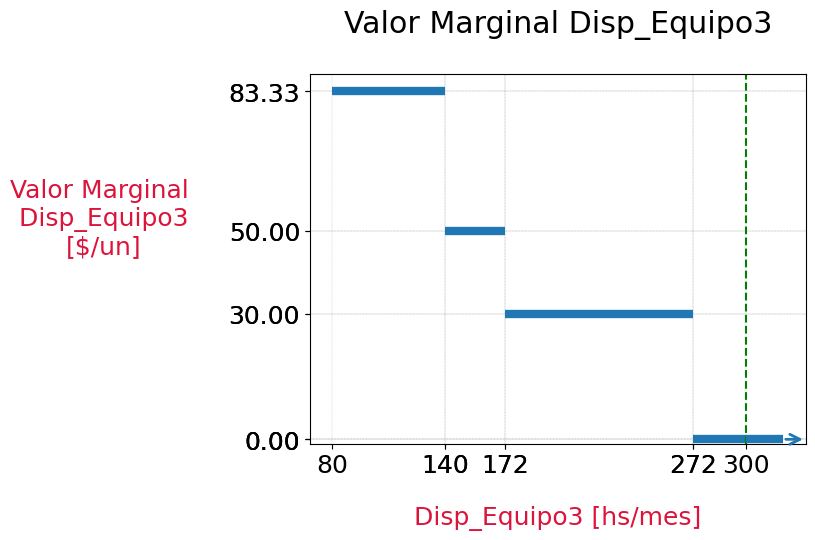

<Figure size 2000x1000 with 0 Axes>

In [ ]:
# AHORA SÍ GRAFICO
plot_text = get_text_for_plot("[hs/mes]", "[$/un]")
plot(rhs_values, dual_values, current_rhs_value, plot_text)